[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
18/18 [==============================] - 8s 100ms/step - loss: 0.0813 - val_loss: 0.0227
Epoch 2/50
18/18 [==============================] - 1s 51ms/step - loss: 0.0151 - val_loss: 0.0022
Epoch 3/50
18/18 [==============================] - 1s 64ms/step - loss: 0.0082 - val_loss: 0.0019
Epoch 4/50
18/18 [==============================] - 2s 91ms/step - loss: 0.0069 - val_loss: 0.0033
Epoch 5/50
18/18 [==============================] - 2s 93ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 6/50
18/18 [==============================] - 1s 63ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 7/50
18/18 [==============================] - 1s 52ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 8/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0092
Test Loss: 0.009185250848531723
3/3 [==============================] - 1s 14ms/step


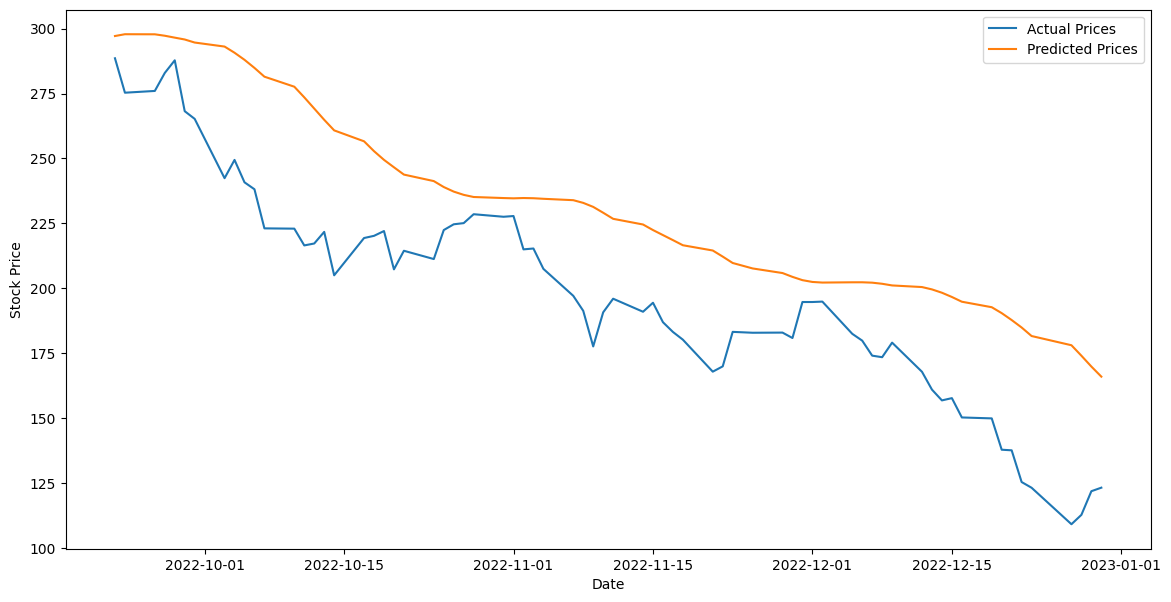

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Downloading the data
stock_data = yf.download('TSLA', start='2020-01-01', end='2023-01-01')
stock_data = stock_data[['Close']]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_stock_data = scaler.fit_transform(stock_data)

# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i, 0])
        targets.append(data[i, 0])
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_stock_data, seq_length)

# Splitting the data into training, validation, and test sets
train_size = int(0.8 * len(X))
val_size = int(0.9 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:val_size], X[val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:val_size], y[val_size:]

# Reshaping the data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Building the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model with validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluating the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Making predictions
predicted_stock_prices = model.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(stock_data.index[seq_length+val_size:], stock_data['Close'][seq_length+val_size:], label='Actual Prices')
plt.plot(stock_data.index[val_size+seq_length:], predicted_stock_prices, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
